In [1]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load images to array
def image_loader(image_paths, width, high):
    data = []
    labels = []
    for (i, image_path) in enumerate(image_paths):
        image = cv2.imread(image_path)
        try:
            image = cv2.resize(image, (width, high))
            label = image_path.split(os.path.sep)[-2]
            data.append(image)
            labels.append(label)
        except:
            print(image_path)  
        if i % 100 == 0:
            print(f"Ladowanie zdjec {i+1}/{len(image_paths)}")
    return np.array(data), np.array(labels)

In [3]:
# check amount of images, show image from each class
def image_count(image_path, show_plot):
    df = pd.DataFrame()
    for path in os.listdir(image_path):
        i = 0
        sub_paths = os.path.join(image_path, path)
        for sub_path in os.listdir(sub_paths):
            if i == 0 and show_plot == True:
                fig = plt.figure()
                ax = fig.add_subplot(111)
                img = cv2.imread(os.path.join(sub_paths, sub_path))
                ax.imshow(img)
                plt.title(sub_paths)
                plt.show()
                print(i)
            if os.path.isfile(os.path.join(sub_paths, sub_path)):
                i += 1
        df = df.append({'Value': i, 'Label': path}, ignore_index=True)
    df.set_index('Label', inplace=True)
    return df

In [4]:
# path to dataset
data_path = (
              'weather'
              )

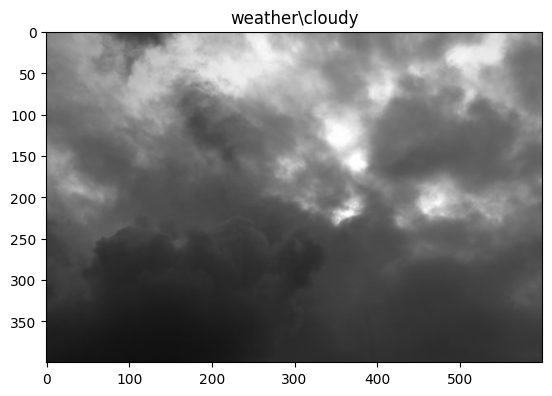

0


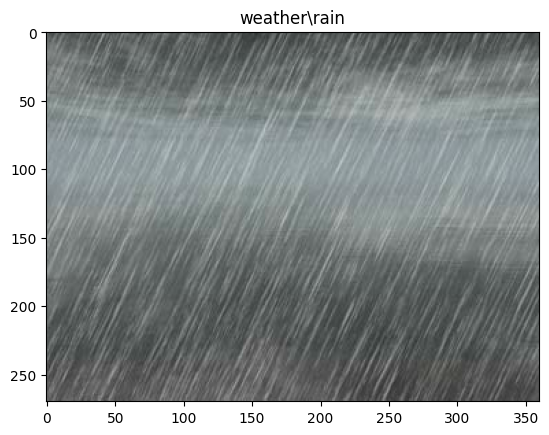

0


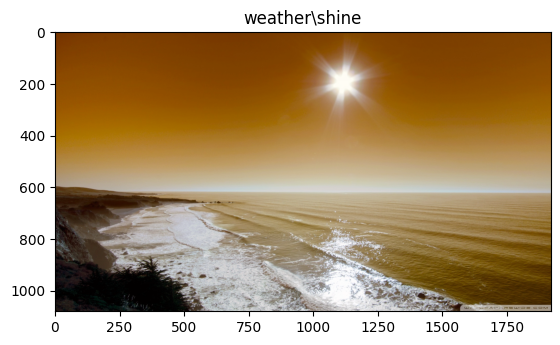

0


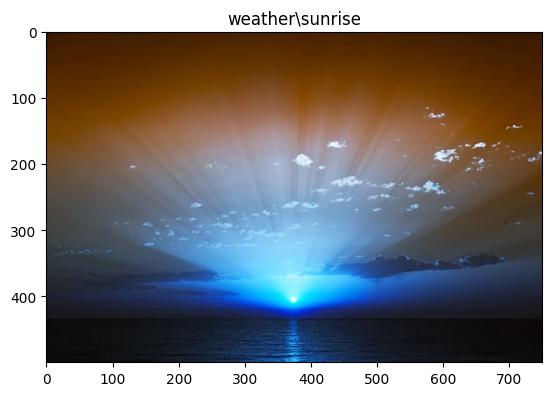

0


<AxesSubplot:xlabel='Label'>

In [5]:
data_paths = list(paths.list_images(data_path))
df = image_count(data_path,False)
image_count(data_path,True).plot.bar(color = ['blue'])

In [6]:
# image size reduction
image_width = 256
image_high = 256

#load images to array
data, labels = image_loader(data_paths, image_width, image_high)

Ladowanie zdjec 1/1125
Ladowanie zdjec 101/1125
Ladowanie zdjec 201/1125
Ladowanie zdjec 301/1125
weather\rain\rain141.jpg
Ladowanie zdjec 401/1125
Ladowanie zdjec 501/1125
weather\shine\shine131.jpg
Ladowanie zdjec 601/1125
Ladowanie zdjec 701/1125
Ladowanie zdjec 801/1125
Ladowanie zdjec 901/1125
Ladowanie zdjec 1001/1125
Ladowanie zdjec 1101/1125


In [7]:
# change labels to numbers
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = labels.reshape(-1,1)
labels = mlb.fit_transform(labels)

In [8]:
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

In [9]:
# amount of epochs, optimizer LR and batch size
EPOCHS = 5
INIT_LR = 1e-3
BS = 32

In [10]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [11]:
# data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom((-0.1,0.1)),
    RandomTranslation(0.1,0.1)
])

In [12]:
# model created manually
model = Sequential()
model.add(Conv2D(input_shape=(image_width,image_high,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(data_augmentation)
model.add(Rescaling(scale=1./255))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=len(labels[1]), activation="softmax"))

In [13]:
opt = Adam(learning_rate=INIT_LR)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [14]:
print("[INFO] training network...")
H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/5
28/28 [==============================] - 518s 18s/step - loss: 1.3887 - accuracy: 0.2921 - val_loss: 1.3791 - val_accuracy: 0.2978
Epoch 2/5
28/28 [==============================] - 494s 18s/step - loss: 1.4124 - accuracy: 0.3291 - val_loss: 1.3778 - val_accuracy: 0.2978
Epoch 3/5
28/28 [==============================] - 529s 19s/step - loss: 1.3665 - accuracy: 0.3256 - val_loss: 1.3763 - val_accuracy: 0.2978
Epoch 4/5
28/28 [==============================] - 418s 15s/step - loss: 1.3836 - accuracy: 0.3291 - val_loss: 1.3749 - val_accuracy: 0.2978
Epoch 5/5
28/28 [==============================] - 405s 14s/step - loss: 1.8232 - accuracy: 0.2898 - val_loss: 1.3664 - val_accuracy: 0.2356


In [55]:
from tensorflow.keras.applications import VGG16
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(image_width,image_high,3))
vgg.trainable = False

In [56]:
#Model 2 data aug and keras app
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(scale=1./255))
model.add(vgg)
model.add(Flatten())
model.add(Dense(units=len(labels[1]), activation="softmax"))

In [57]:
opt = Adam(learning_rate=INIT_LR)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [58]:
print("[INFO] training network...")
H = model.fit(
    x=aug.flow(trainX, trainY),# batch_size=BS*),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/5
28/28 [==============================] - 98s 3s/step - loss: 1.0335 - accuracy: 0.6259 - val_loss: 0.4116 - val_accuracy: 0.8800
Epoch 2/5
28/28 [==============================] - 95s 3s/step - loss: 0.3959 - accuracy: 0.8684 - val_loss: 0.2720 - val_accuracy: 0.9067
Epoch 3/5
28/28 [==============================] - 107s 4s/step - loss: 0.3157 - accuracy: 0.8880 - val_loss: 0.3112 - val_accuracy: 0.8800
Epoch 4/5
28/28 [==============================] - 102s 4s/step - loss: 0.2788 - accuracy: 0.9076 - val_loss: 0.2517 - val_accuracy: 0.9067
Epoch 5/5
28/28 [==============================] - 92s 3s/step - loss: 0.2556 - accuracy: 0.9111 - val_loss: 0.2602 - val_accuracy: 0.9156


#Test predictions

In [78]:
# load images to array
def load_prediction(image_paths, width, high, model, df):
    data = []
    prediction_paths = []
    for (i, image_path) in enumerate(image_paths):
        image = cv2.imread(image_path)
        try:
            image = cv2.resize(image, (width, high))
            data.append(image)
            prediction_paths.append(image_path)
        except:
            print(image_path)  
    predictions = model.predict(np.array(data))
    for j, prediction_path in enumerate(prediction_paths):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        img = cv2.imread(prediction_path)
        ax.imshow(img)
        idxs = np.argsort(predictions)
        plt.title('Prediction: '+ df.index[idxs[j][-1]]+ ' Result:' + str(max(predictions[0])) )
        

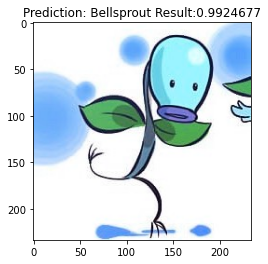

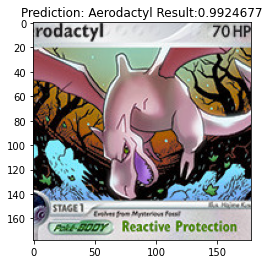

In [79]:
# path to dataset
pred_path = (
              'test_pred'
              )
pred_paths = list(paths.list_images(pred_path))
load_prediction(pred_paths, image_width, image_high, model, df)

In [80]:
tf.test.is_built_with_cuda()

True

In [ ]:
python -m ipykernel install –user –name=gpu2